### **1. Import necessary libraries and modules**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

from custom_loss_functions import SCCE, SCCEInverse, SCCEMinMaxBin, SCCEMaxBin, SCCEDifference
from custom_layers import DefaultDense, RowWiseQuantized, RowWiseQuantizedSTE, ColumnWiseQuantized, ColumnWiseQuantizedSTE
from custom_callbacks import ScaleTrackingCallback, LossTrackingCallback, AccuracyTrackingCallBack
from utils import print_model_structure, count_unique_values

/Users/anuunchinbat/Desktop/Thesis/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### **2. Import MNIST data:**

In [2]:
# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

### **3. Define model layers**

The custom `RowWiseQuantizedSTE` can be replaced with other custom layer classes. Refer to `custom_layers.py`.

In [3]:
input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = RowWiseQuantizedSTE(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = RowWiseQuantizedSTE(10, activation='softmax')(dense_output)
quantized_model = Model(inputs=input_layer, outputs=output_layer)

### **4. Print model structure for timely inspection**

In [4]:
print_model_structure(quantized_model)


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x160a37340>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x160a372e0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantizedSTE object at 0x16372cd00>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <custom_layers.RowWiseQuantizedSTE object at 0x15df21130>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)
--------------------------------------------------------------------------------


### **5. Initialize a custom loss function and compile the model**
The `SCCEMinMaxBin` can be replaced with other loss function objects. Refer to `custom_loss_functions.py`.

In [5]:

# Initialize your custom loss function
loss_function = SCCEMinMaxBin(
    layers=[
        quantized_model.get_layer(index=2),
        quantized_model.get_layer(index=3)
    ],
    penalty_rate=0.1,
    row_wise=1 # 1 = True = scale factor values are applied row-wise, must match the used custom layer (RowWiseQuantized)
               # 0 = False = scale factor values are applied column-wise, must match the used custom layer (ColumnWiseQuantized)
)

# Compile your model
quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=loss_function.compute_total_loss,
    metrics=['accuracy']
)


### **6. Initialize callbacks, train and evaluate the model**

In [6]:
# Initialize your callbacks
scale_tracking_callback_first_dense_layer = ScaleTrackingCallback(quantized_model.get_layer(index=2))
scale_tracking_callback_second_dense_layer = ScaleTrackingCallback(quantized_model.get_layer(index=3))
penalty_callback = LossTrackingCallback(loss_function=loss_function)
accuracy_callback = AccuracyTrackingCallBack(quantized_model.get_layer(index=3))

# Train your model
quantized_model.fit(
    x_train, y_train,
    epochs=2,
    validation_data=(x_test, y_test),
    callbacks=[
        scale_tracking_callback_first_dense_layer,
        scale_tracking_callback_second_dense_layer,
        penalty_callback,
        accuracy_callback
    ]
)

# Evaluate
loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

Epoch 1/2
1875/1875 [==============================] - 7s 4ms/step - loss: 99.5035 - accuracy: 0.8020 - val_loss: 3.0208 - val_accuracy: 0.8517
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 2.3909 - accuracy: 0.8817
Quantized Model Test Accuracy: 0.8816999793052673


### **7. Plot the scale factor values, accuracy and loss**

/Users/anuunchinbat/Desktop/Thesis/qat/custom_callbacks.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


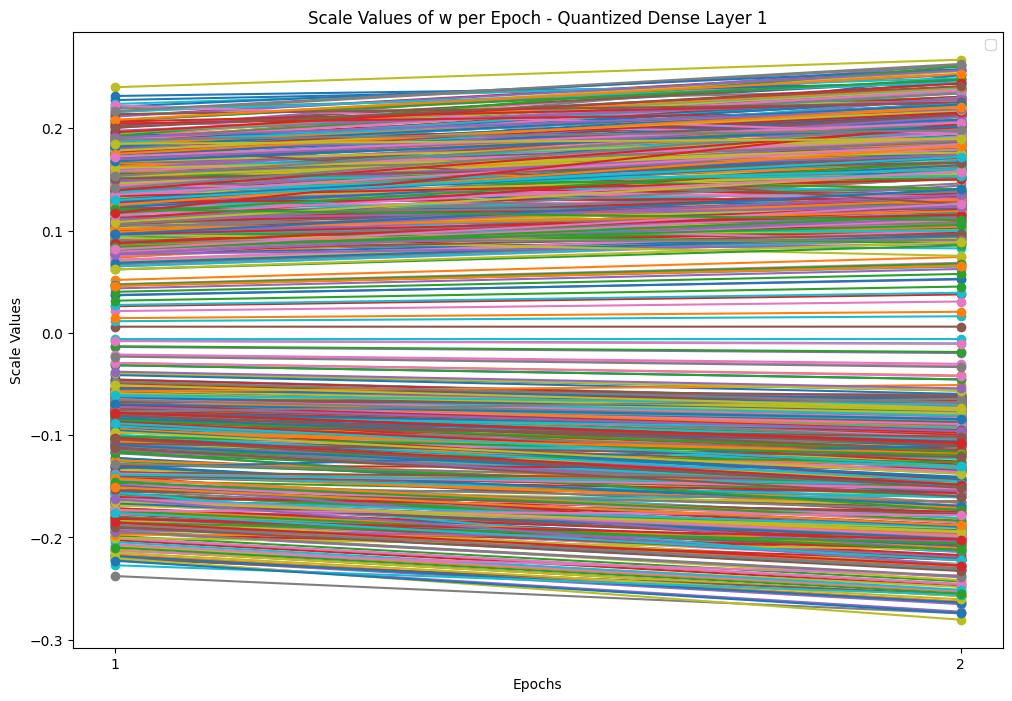

/Users/anuunchinbat/Desktop/Thesis/qat/custom_callbacks.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


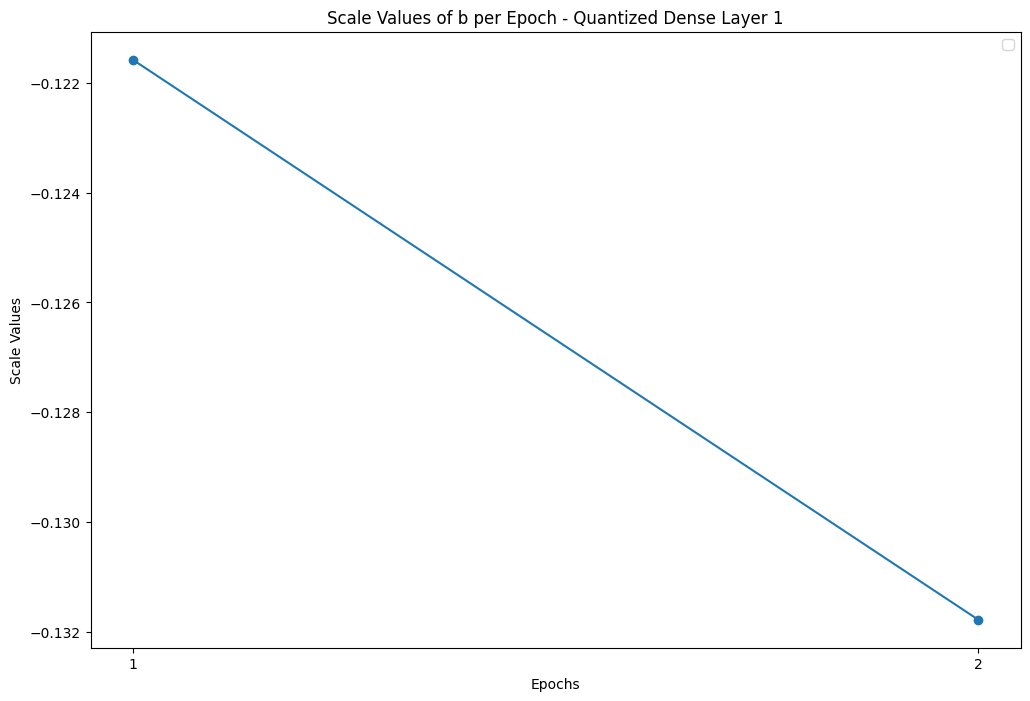

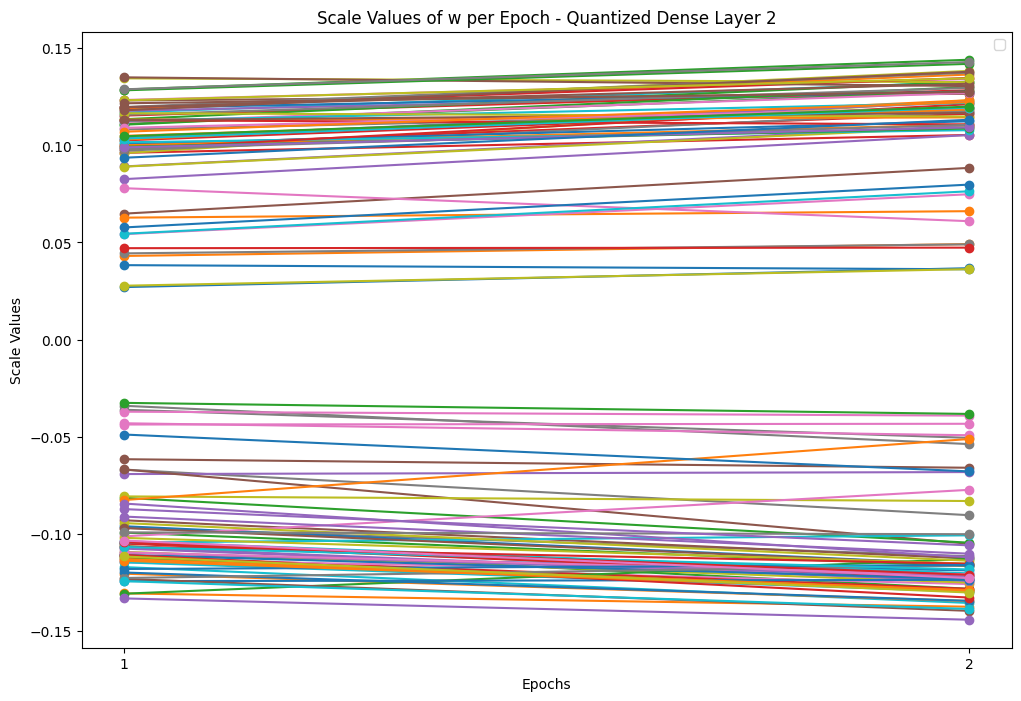

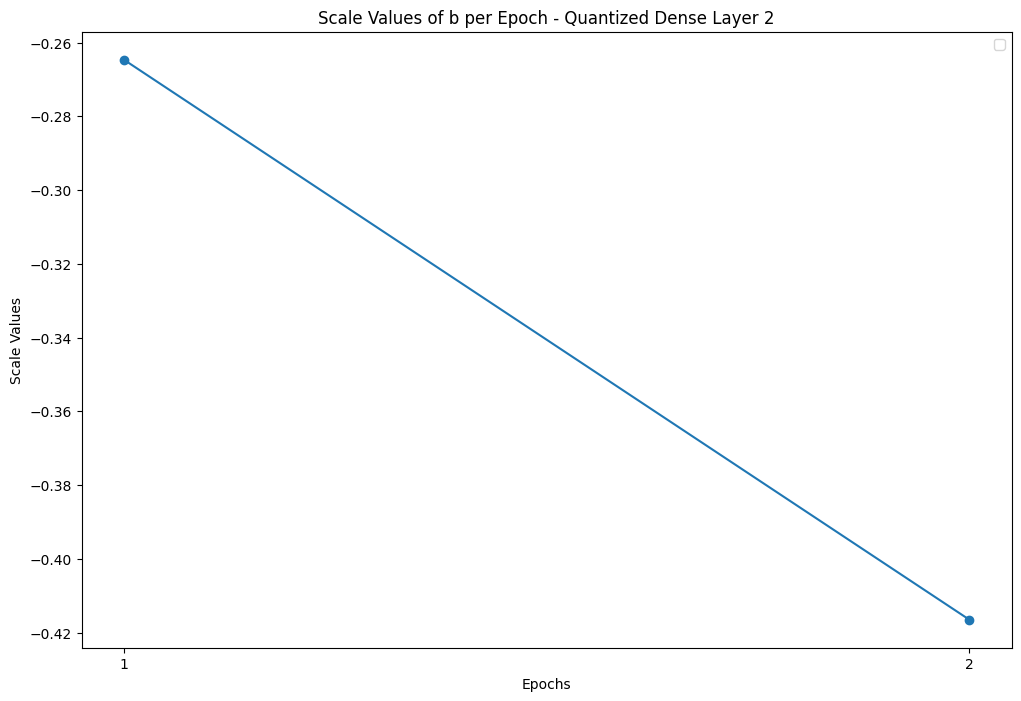

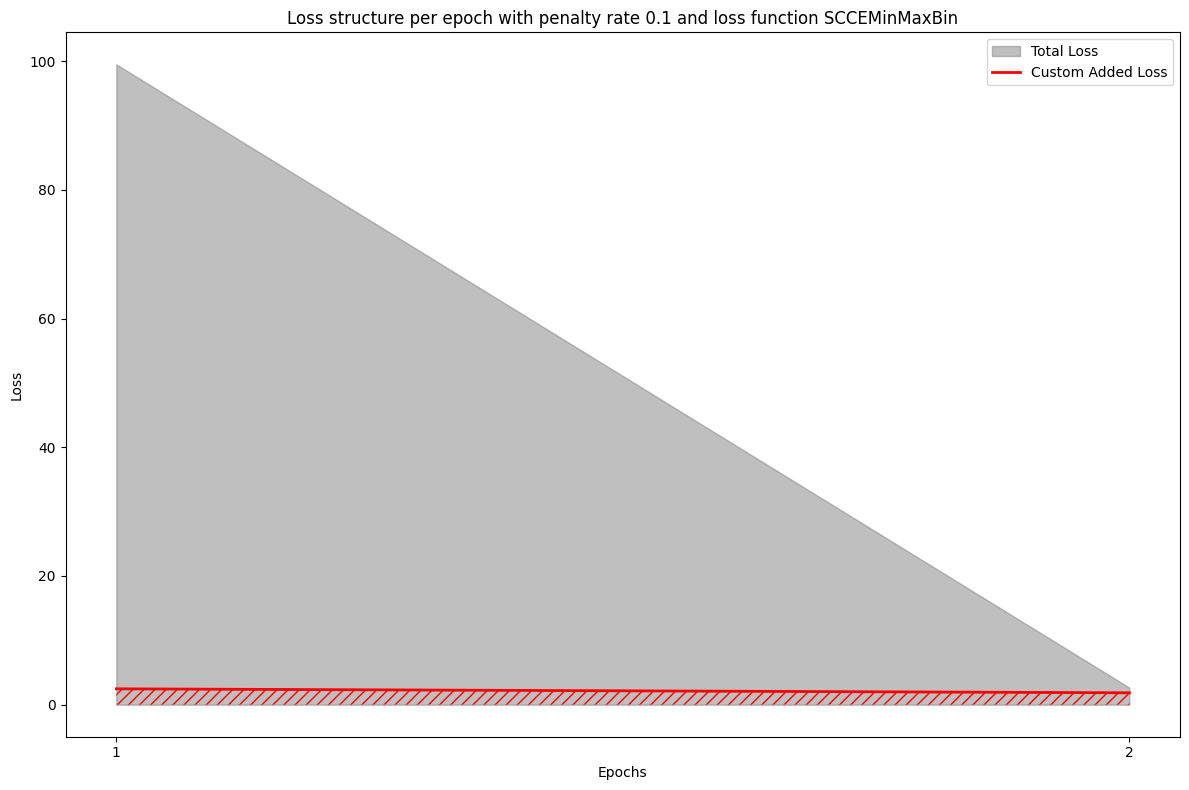

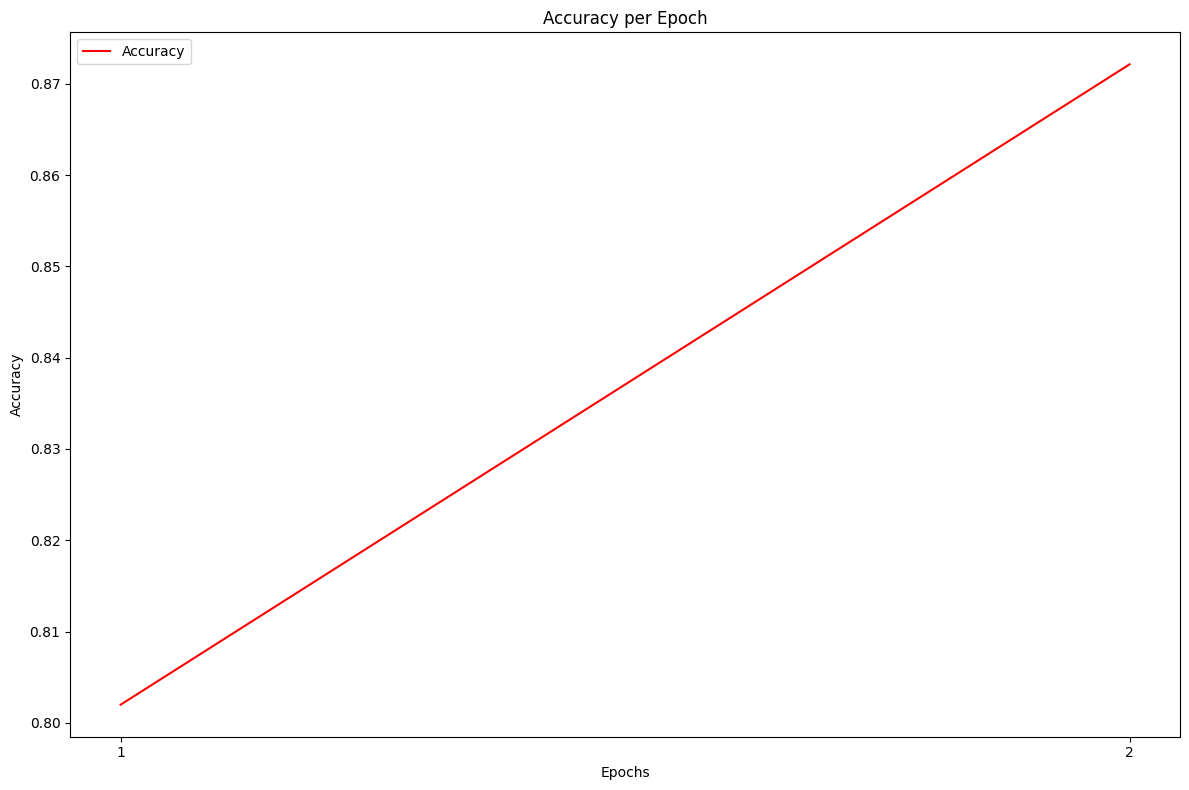

In [7]:
# Plot
scale_tracking_callback_first_dense_layer.plot_scale_values(layer_name="Quantized Dense Layer 1")
scale_tracking_callback_second_dense_layer.plot_scale_values(layer_name="Quantized Dense Layer 2")
penalty_callback.plot_loss()
accuracy_callback.plot_accuracy()

### **8. Before & After quantization**

In [8]:

# Count number of unique values for w and b before and after quantization for each custom layer
count_unique_values(quantized_model)


--------------------------------------------------------------------------------
NUMBER OF UNIQUE VALUES FOR W AND B OF EACH CUSTOM LAYER

LAYER WITH ID: 2
Unique values in w:  100292
Unique values in quantized w:  42
Unique values in b:  128
Unique values in quantized b:  2

LAYER WITH ID: 3
Unique values in w:  1280
Unique values in quantized w:  7
Unique values in b:  10
Unique values in quantized b:  4

--------------------------------------------------------------------------------
